In [52]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import random

In [ ]:
RETRAIN = True
PATH = 'cnn_model_q2'

In [53]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [54]:
def set_seeds(SEED):
	torch.manual_seed(SEED)
	np.random.seed(SEED * 2)
	random.seed(SEED * 3)

set_seeds(123)

In [55]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


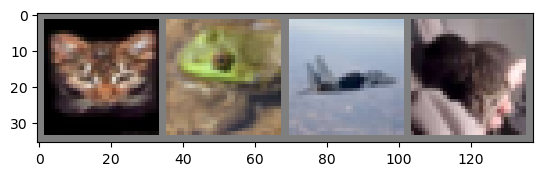

cat   frog  plane cat  


In [56]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [57]:
class Net(nn.Module):
    def __init__(self, reconstruction_weight=1):
        super().__init__()
        self.rec_weight = reconstruction_weight
        
        self.L_ce = nn.CrossEntropyLoss()
        self.L_rec = nn.MSELoss()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.deconv1 = nn.ConvTranspose2d(6, 3, 5)
        
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.deconv2 = nn.ConvTranspose2d(16, 6, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y_tilde_temp, indices1 = self.pool(F.relu(self.conv1(x)))
        y_tilde_temp, indices2 = self.pool(F.relu(self.conv2(y_tilde_temp)))
        
        x_tilde_temp = self.deconv2(F.relu(self.unpool(y_tilde_temp, indices2)))
        x_tilde = self.deconv1(F.relu(self.unpool(x_tilde_temp, indices1)))
        
        y_tilde_temp = torch.flatten(y_tilde_temp, 1) # flatten all dimensions except batch
        y_tilde_temp = F.relu(self.fc1(y_tilde_temp))
        y_tilde_temp = F.relu(self.fc2(y_tilde_temp))
        y_tilde = self.fc3(y_tilde_temp)
        
        return y_tilde, x_tilde
    
    def total_loss(self,x ,x_tilde, y, y_tilde):
        cross_entropy = self.L_ce(y_tilde, y)
        reconstruction_element = self.L_rec(x, x_tilde)
        
        return cross_entropy + self.rec_weight*reconstruction_element

In [58]:
net = Net( reconstruction_weight=0.25 )
net.to(device)

Net(
  (L_ce): CrossEntropyLoss()
  (L_rec): MSELoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [59]:
import torch.optim as optim

criterion = net.total_loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [60]:
if RETRAIN:
    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_tilde, x_tilde = net(inputs)
            loss = criterion(x=inputs, x_tilde=x_tilde, y=labels, y_tilde=y_tilde)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[epoch={epoch + 1}, batches={i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    
else:
    # Load the saved model
    net = Net()
    net.load_state_dict(torch.load(PATH))
    net.to(device)

[epoch=1, batches= 2000] loss: 2.235
[epoch=1, batches= 4000] loss: 1.856
[epoch=1, batches= 6000] loss: 1.693
[epoch=1, batches= 8000] loss: 1.608
[epoch=1, batches=10000] loss: 1.532
[epoch=1, batches=12000] loss: 1.484
[epoch=2, batches= 2000] loss: 1.410
[epoch=2, batches= 4000] loss: 1.397
[epoch=2, batches= 6000] loss: 1.359
[epoch=2, batches= 8000] loss: 1.347
[epoch=2, batches=10000] loss: 1.323
[epoch=2, batches=12000] loss: 1.300
Finished Training


In [61]:
print(net.rec_weight)

0.25


In [62]:
# Save the trained model
torch.save(net.state_dict(), PATH)

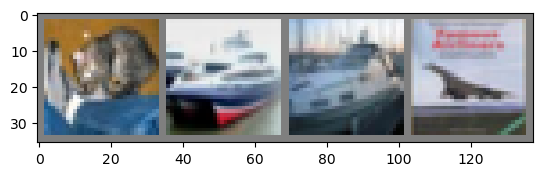

GroundTruth:  cat   ship  ship  plane


In [63]:
# Display a batch from the test data
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [64]:
# Load the saved model
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (L_ce): CrossEntropyLoss()
  (L_rec): MSELoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [65]:
print(net.rec_weight)

1


In [66]:
# Get predictions for the above images and compare to labels
outputs,_ = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [71]:
hidden_features = None

def hidden_features_hook(module, input, output):
	global hidden_features
	hidden_features = output.detach()


net.deconv1.register_forward_hook(hidden_features_hook)

In [98]:
def imshow_reconstructed(tensor):
    # print(f"Before de-normalization: max={torch.max(tensor)}, min={torch.min(tensor)}")
    tensor -= tensor.amin(dim=(1,2,3), keepdim=True)
    tensor /= tensor.amax(dim=(1,2,3), keepdim=True)
    # print(f"After de-normalization: max={torch.max(tensor)}, min={torch.min(tensor)}")
        
    npimg = torchvision.utils.make_grid(tensor).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

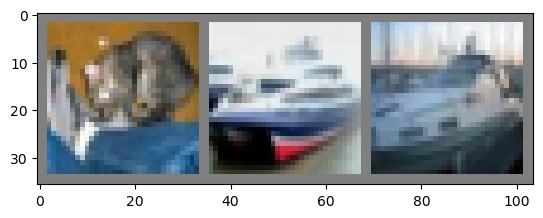

Before de-normalization: max=1.8810125589370728, min=-0.7693812847137451
After de-normalization: max=1.0, min=0.0


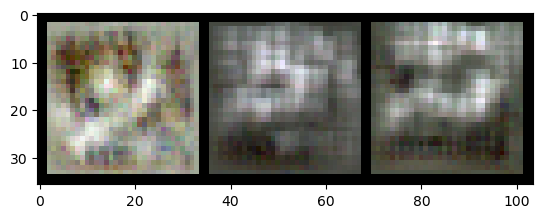

Accuracy of the network on the 10000 test images: 55 %


In [102]:
# Network performace on the whole dataset
correct = 0
total = 0
print_hidden_features_batch = True

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs, _ = net(images)
        
        if print_hidden_features_batch:
            print_hidden_features_batch = False
            images = images[:3]
            hidden_features = hidden_features[:3]
            
            imshow(torchvision.utils.make_grid(images))
            imshow_reconstructed(hidden_features)
            # break
            
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [69]:

# Check the classes that performed well, and the classes that did not perform well
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs, _ = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.3 %
Accuracy for class: car   is 62.3 %
Accuracy for class: bird  is 31.3 %
Accuracy for class: cat   is 44.6 %
Accuracy for class: deer  is 56.9 %
Accuracy for class: dog   is 38.3 %
Accuracy for class: frog  is 56.6 %
Accuracy for class: horse is 60.8 %
Accuracy for class: ship  is 72.0 %
Accuracy for class: truck is 74.3 %
